# Data Augmentation and its effects

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the libraries and dependencies
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib and seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s eta 0:00:01


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import IPython, librosa, keras
import matplotlib.pyplot as plt
%matplotlib inline

BATCH_SIZE = 512
EPOCHS = 200
CLASSES = 10
IMG_DIM = (32, 32, 3)
SHUFFLE = False
ACCURACY_THRESHOLD = 0.98
LEARNING_RATE = 0.001
SEED = 11

There are three helper methods :-
- seed_everthing - sets the seed for numpy, tensorflow and random modules so that when we try and replicate a result we can do so if the seeds are same.
- clear_tf - clears the backend of the tensorflow module.

In [ ]:
def seed_everything(n):
    np.random.seed(n)
    tf.random.set_seed(n)

def clear_tf():
    tf.keras.backend.clear_session()

# Part 1

## Loading Data
The following block of code loads CIFAR data in two formats.
- First is through the dataset module from keras which loads data in numpy arrays.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensirflow_dataset module.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

(df_train, ds_val, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:45000]', 'train[45000:]', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

170508288/170498071 [==============================] - 6s 0us/step


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteLXMNDI/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteLXMNDI/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

## Labels
The Labels of the dataset.

In [ ]:
{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names}

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Visualization of few of the images contained in the training set with there respective labels

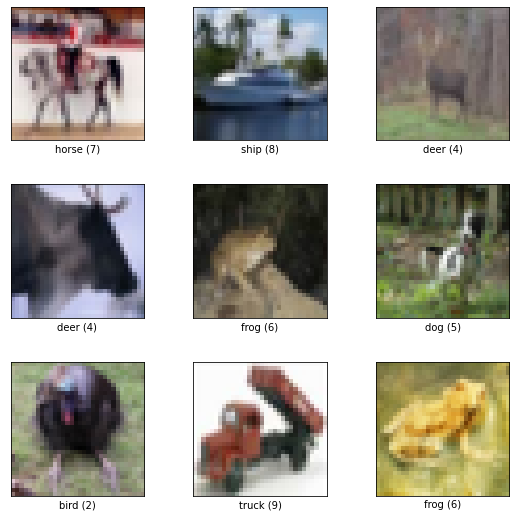

In [ ]:
fig = tfds.show_examples(df_train, ds_info)

Processing the dataset and turning each set into a trainable and testable sets.

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32) / 255.
    return 2*(image - 0.5), tf.one_hot(label, depth = 10)
    
ds_train = df_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train[:45000]'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Model architecture Declaration methods

- Model - this method defines a common method which will used commonly accross all the question to define a Deep Learning model.

In [ ]:
def Model(dim = IMG_DIM, 
          final_layer_units = 10,
          activation_fn = "relu",
          initializer = tf.initializers.HeNormal(),
          optimizer = tf.keras.optimizers.Adam()):
    inp = tf.keras.layers.Input(shape=(dim))
    layer = tf.keras.layers.Conv2D(10, kernel_size=5, strides=1, 
                                   activation=activation_fn, kernel_initializer=initializer)(inp)
    layer = tf.keras.layers.MaxPooling2D(2, strides=2)(layer)
    layer = tf.keras.layers.Conv2D(10, kernel_size=5, strides=1, 
                                   activation=activation_fn, kernel_initializer=initializer)(layer)
    layer = tf.keras.layers.MaxPooling2D(2, strides=2)(layer)
    layer = tf.keras.layers.Flatten()(layer)
    layer = tf.keras.layers.Dense(20, activation=activation_fn, 
                                  kernel_initializer=initializer)(layer)
    out = tf.keras.layers.Dense(final_layer_units, activation="softmax", 
                                kernel_initializer=initializer)(layer)
    model = tf.keras.models.Model(inputs= inp, outputs=out)
    # model.compile(metrics = ['accuracy'],
    #               loss = 'categorical_crossentropy',
    #               optimizer = optimizer)
    return model
Model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        760       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 10)        2510      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                5020  

## Training

In [ ]:
model = Model()
model.compile(metrics = ['accuracy'],
              loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam())
model.fit(ds_train, validation_data = ds_val, epochs = EPOCHS)

Epoch 1/200
88/88 [==============================] - 25s 19ms/step - loss: 2.1037 - accuracy: 0.2241 - val_loss: 1.8237 - val_accuracy: 0.3404
Epoch 2/200
88/88 [==============================] - 1s 7ms/step - loss: 1.6838 - accuracy: 0.3855 - val_loss: 1.5908 - val_accuracy: 0.4156
Epoch 3/200
88/88 [==============================] - 1s 7ms/step - loss: 1.5347 - accuracy: 0.4401 - val_loss: 1.4870 - val_accuracy: 0.4554
Epoch 4/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4609 - accuracy: 0.4698 - val_loss: 1.4379 - val_accuracy: 0.4792
Epoch 5/200
88/88 [==============================] - 1s 7ms/step - loss: 1.4115 - accuracy: 0.4876 - val_loss: 1.3905 - val_accuracy: 0.5002
Epoch 6/200
88/88 [==============================] - 1s 7ms/step - loss: 1.3712 - accuracy: 0.5038 - val_loss: 1.3583 - val_accuracy: 0.5094
Epoch 7/200
88/88 [==============================] - 1s 7ms/step - loss: 1.3412 - accuracy: 0.5165 - val_loss: 1.3320 - val_accuracy: 0.5206
Epoch 8/200

## Plot for the training set (without augmentation)

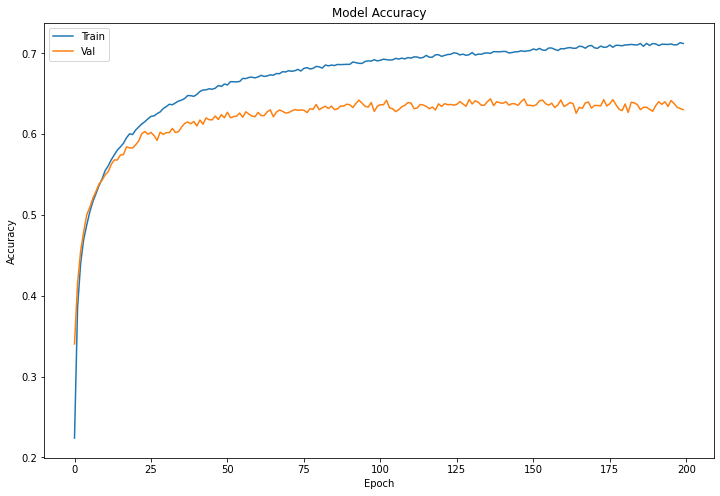

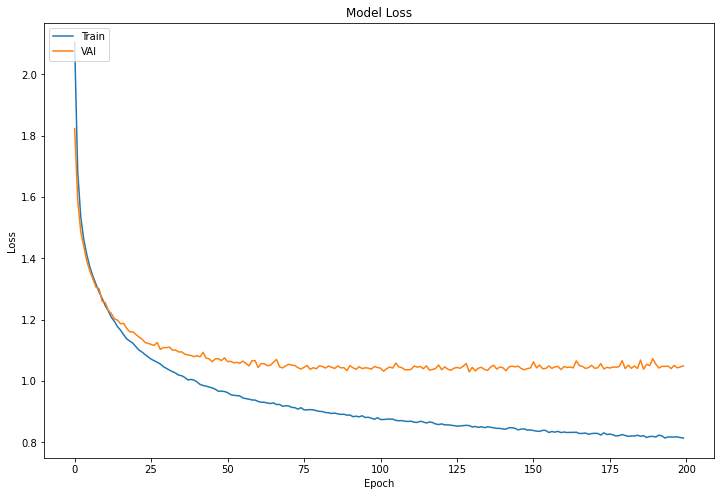

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'VAl'], loc='upper left')
plt.show()

## Data Augmentationa and new training set preperation
- Brigthen the imgae
- Darken each pixel of the image
- Flip the image left_right

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, depth = 10)

In [ ]:
def Augment_Brigthen(image, label):
    return tf.math.minimum(tf.multiply(1.1, image), 1), label

ds_train_2 = df_train.map(normalize_img,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_2 = ds_train_2.map(Augment_Brigthen,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
# ds_train_2 = ds_train_2.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train[:45000]'].num_examples)
# ds_train_2 = ds_train_2.batch(BATCH_SIZE)
# ds_train_2 = ds_train_2.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def Augment_Darken(image, label):
    return tf.cast(tf.multiply(0.9, image), tf.float32), label

ds_train_3 = df_train.map(normalize_img,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_3 = ds_train_3.map(Augment_Darken, 
                          num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_train_3 = ds_train_3.cache()
# ds_train_3 = ds_train_3.shuffle(ds_info.splits['train[:45000]'].num_examples)
# ds_train_3 = ds_train_3.batch(BATCH_SIZE)
# ds_train_3 = ds_train_3.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def Augment_Flip(image, label):
    return tf.image.flip_left_right(image), label
    
ds_train_4 = df_train.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_4 = ds_train_4.map(Augment_Flip, 
                            num_parallel_calls = tf.data.experimental.AUTOTUNE)
# ds_train_4 = ds_train_4.cache()
# ds_train_4 = ds_train_4.shuffle(ds_info.splits["train[:45000]"].num_examples)
# ds_train_4 = ds_train_4.batch(BATCH_SIZE)
# ds_train_4 = ds_train_4.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def normalize_img_range(image, label):
    # image = tf.cast(image, tf.float32) / 255.
    return 2*(image - 0.5), label

temp_ds_train = df_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = temp_ds_train.concatenate(ds_train_2).concatenate(ds_train_3).concatenate(ds_train_4)

ds = ds.map(normalize_img_range, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.cache()
ds = ds.shuffle(45000*4)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

## Model trainng with data sugmentation

In [ ]:
model_augmented = Model()
model_augmented.compile(metrics = ['accuracy'],
              loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam())
model_augmented.fit(ds, validation_data = ds_val, epochs = 200)

Epoch 1/200
352/352 [==============================] - 17s 7ms/step - loss: 1.7148 - accuracy: 0.3738 - val_loss: 1.4665 - val_accuracy: 0.4652
Epoch 2/200
352/352 [==============================] - 3s 7ms/step - loss: 1.4060 - accuracy: 0.4950 - val_loss: 1.3574 - val_accuracy: 0.5096
Epoch 3/200
352/352 [==============================] - 3s 7ms/step - loss: 1.3033 - accuracy: 0.5354 - val_loss: 1.2893 - val_accuracy: 0.5394
Epoch 4/200
352/352 [==============================] - 3s 7ms/step - loss: 1.2384 - accuracy: 0.5588 - val_loss: 1.2773 - val_accuracy: 0.5524
Epoch 5/200
352/352 [==============================] - 3s 7ms/step - loss: 1.1976 - accuracy: 0.5748 - val_loss: 1.2132 - val_accuracy: 0.5660
Epoch 6/200
352/352 [==============================] - 3s 7ms/step - loss: 1.1622 - accuracy: 0.5901 - val_loss: 1.1869 - val_accuracy: 0.5862
Epoch 7/200
352/352 [==============================] - 3s 7ms/step - loss: 1.1350 - accuracy: 0.6010 - val_loss: 1.1541 - val_accuracy: 0.596

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


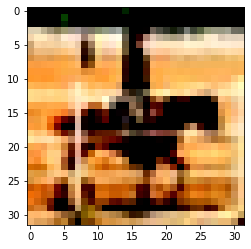

In [ ]:
for i in tfds.as_numpy(ds.take(1)):
    plt.imshow(i[0][0])
    print(i[1][0])

## Plot for the training set (with augmentation)

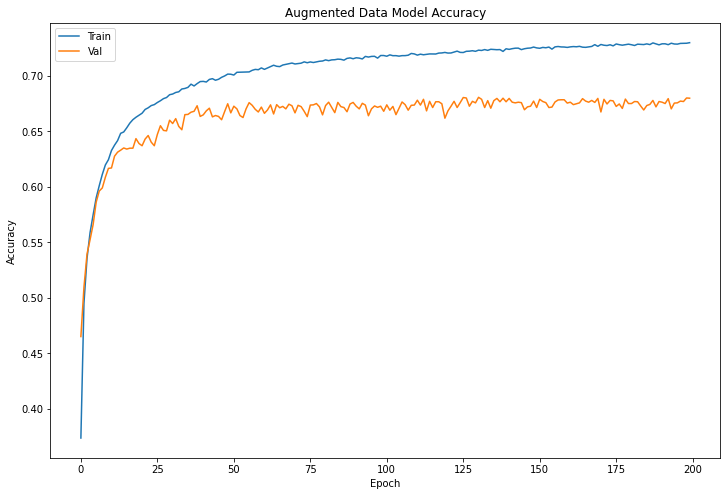

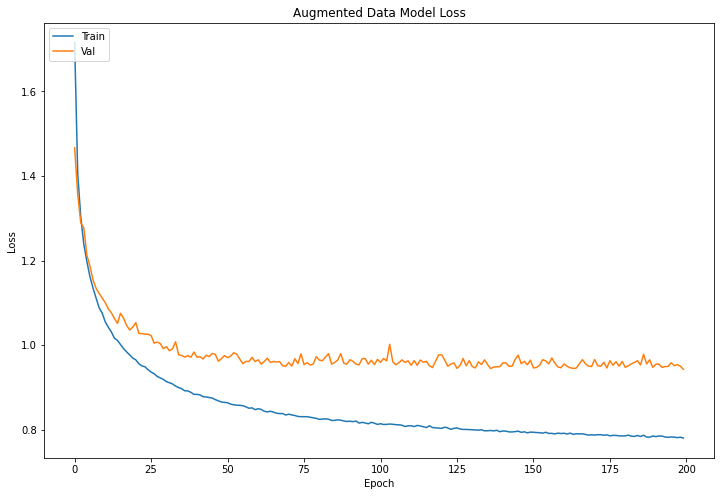

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(model_augmented.history.history['accuracy'])
plt.plot(model_augmented.history.history['val_accuracy'])
plt.title('Augmented Data Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(model_augmented.history.history['loss'])
plt.plot(model_augmented.history.history['val_loss'])
plt.title('Augmented Data Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Comparison - Augmented data training vs Normal Training

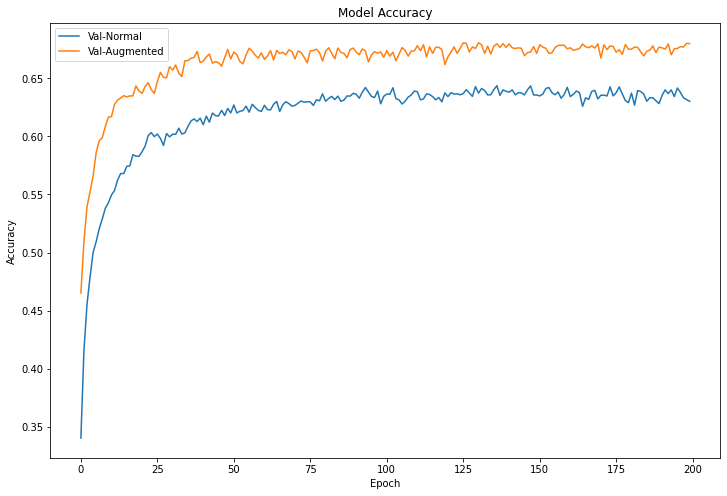

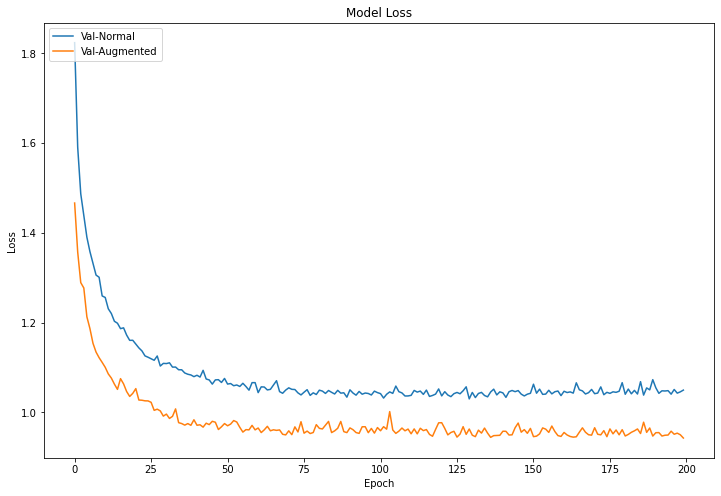

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(model.history.history['val_accuracy'])
plt.plot(model_augmented.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Val-Normal', 'Val-Augmented'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(12,8))
plt.plot(model.history.history['val_loss'])
plt.plot(model_augmented.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Val-Normal', 'Val-Augmented'], loc='upper left')
plt.show()

# Part 2

## Loading data in the following format:
- Seperating the last 500 records for 2nd training dataset
- First 49500 will be used for creating a augmented dataset
- The testing set is being used as validation set

In [ ]:
(df_train_49500, ds_train_500, ds_val), ds_info = tfds.load(
    'cifar10',
    split=['train[:49500]', 'train[49500:]', 'test'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

Number of each labels in the 500 training set

In [ ]:
c = {}
for i in tfds.as_numpy(ds_train_500.take(-1)):
    if i[1] in c:
        c[i[1]]+=1
    else:
        c[i[1]]=1
c

{0: 53, 1: 46, 2: 40, 3: 35, 4: 53, 5: 65, 6: 42, 7: 55, 8: 52, 9: 59}

Changing the batchsize for the 500 model to 16

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # print(label)
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, depth = 10)

ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

ds_train_500 = ds_train_500.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train_500 = ds_train_500.batch(16)
ds_train_500 = ds_train_500.cache()
ds_train_500 = ds_train_500.prefetch(tf.data.experimental.AUTOTUNE)

def normalize_img_new_label_0(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    label = 0
    return tf.cast(image, tf.float32) / 255., label
    
ds_train_0 = df_train_49500.map(
    normalize_img_new_label_0, num_parallel_calls=tf.data.experimental.AUTOTUNE)

def Augment_Flip_up_down_normalize(image, label):
    label = 1
    image = tf.cast(image, tf.float32) / 255.
    return tf.image.flip_up_down(image), label
    
ds_train_1 = df_train_49500.map(Augment_Flip_up_down_normalize,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

def Rotate_90_normalize(image, label):
    label = 2
    image = tf.cast(image, tf.float32) / 255.
    return tf.image.rot90(image), label
    
ds_train_2 = df_train_49500.map(Rotate_90_normalize,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)

df = ds_train_0.concatenate(ds_train_1).concatenate(ds_train_2)

pandas_df = tfds.as_dataframe(df.take(-1), ds_info)

def change_labels(image, label):
    return image, tf.one_hot(label, depth = 3)

df = df.map(change_labels, 
            num_parallel_calls = tf.data.experimental.AUTOTUNE)
df = df.shuffle(148500)
df = df.batch(BATCH_SIZE)
df = df.cache()
df = df.prefetch(tf.data.experimental.AUTOTUNE)

Checking the dataset

In [ ]:
pandas_df.label.unique(), pandas_df.shape

(array([0, 1, 2]), (148500, 2))

## Weights training on Augmented Dataset

In [ ]:
EPOCHS = 100

model_3class = Model(final_layer_units = 3)
model_3class.compile(metrics = ['accuracy'],
                  loss = 'categorical_crossentropy',
                  optimizer = 'adam')

model_3class.fit(df, epochs = EPOCHS)
model_3class.save_weights("weights_question2_3classes.h5")
model_3class.save("my_h5_model.h5")

Epoch 1/100
291/291 [==============================] - 14s 11ms/step - loss: 0.9210 - accuracy: 0.5542
Epoch 2/100
291/291 [==============================] - 2s 6ms/step - loss: 0.8147 - accuracy: 0.6251
Epoch 3/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7827 - accuracy: 0.6468
Epoch 4/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7600 - accuracy: 0.6608
Epoch 5/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7407 - accuracy: 0.6730
Epoch 6/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7271 - accuracy: 0.6808
Epoch 7/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7169 - accuracy: 0.6865
Epoch 8/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7074 - accuracy: 0.6915
Epoch 9/100
291/291 [==============================] - 2s 6ms/step - loss: 0.7002 - accuracy: 0.6949
Epoch 10/100
291/291 [==============================] - 2s 6ms/step - loss: 0.6932 - accu

In [ ]:
del pandas_df
clear_tf()

## Baseline model Training

In [ ]:
EPOCHS = 10000

model_500_baseline = Model()
model_500_baseline.compile(metrics = ['accuracy'],
                  loss = 'categorical_crossentropy',
                  optimizer = 'adam')

model_500_baseline.fit(ds_train_500, validation_data = ds_val, epochs = EPOCHS)

Streaming output truncated to the last 5000 lines.
32/32 [==============================] - 0s 7ms/step - loss: 1.4553e-05 - accuracy: 1.0000 - val_loss: 18.9346 - val_accuracy: 0.3132
Epoch 7502/10000
32/32 [==============================] - 0s 7ms/step - loss: 1.4241e-05 - accuracy: 1.0000 - val_loss: 18.9380 - val_accuracy: 0.3132
Epoch 7503/10000
32/32 [==============================] - 0s 7ms/step - loss: 1.3943e-05 - accuracy: 1.0000 - val_loss: 18.9414 - val_accuracy: 0.3133
Epoch 7504/10000
32/32 [==============================] - 0s 7ms/step - loss: 1.3645e-05 - accuracy: 1.0000 - val_loss: 18.9448 - val_accuracy: 0.3133
Epoch 7505/10000
32/32 [==============================] - 0s 7ms/step - loss: 1.3364e-05 - accuracy: 1.0000 - val_loss: 18.9481 - val_accuracy: 0.3132
Epoch 7506/10000
32/32 [==============================] - 0s 7ms/step - loss: 1.3092e-05 - accuracy: 1.0000 - val_loss: 18.9514 - val_accuracy: 0.3132
Epoch 7507/10000
32/32 [==============================] - 0s

In [ ]:
np.save('my_baseline_history.npy',model_500_baseline.history.history)
# history=np.load('my_baseline_history.npy',allow_pickle='TRUE').item()

## Plot for Baseline model Training

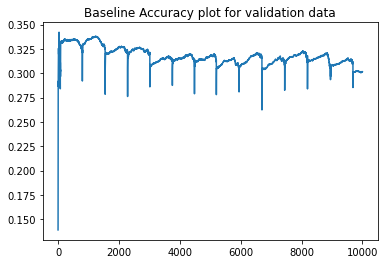

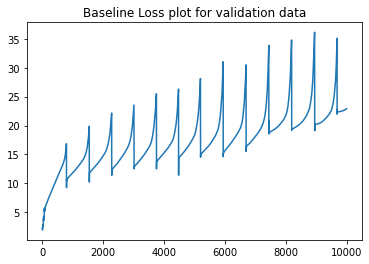

In [ ]:
plt.plot(model_500_baseline.history.history["val_accuracy"])
plt.title("Baseline Accuracy plot for validation data")
plt.show()

plt.plot(model_500_baseline.history.history["val_loss"])
plt.title("Baseline Loss plot for validation data")
plt.show()

## Transfer weights from the Augmented model learned before and train on 500 examples

In [ ]:
reconstructed_model = tf.keras.models.load_model("/content/drive/MyDrive/model/my_h5_model.h5")
reconstructed_model.summary()

layer = reconstructed_model.layers[-2].output
out = tf.keras.layers.Dense(10, "softmax")(layer)
transfer_model = tf.keras.models.Model(inputs = reconstructed_model.input, outputs = out)

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    tf.keras.optimizers.Adam()
]
optimizers_and_layers = [(optimizers[0], transfer_model.layers[:-1]),  
                         (optimizers[1], transfer_model.layers[-1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

transfer_model.compile(metrics = ['accuracy'],
                    loss = 'categorical_crossentropy',
                    optimizer = optimizer)
transfer_model.fit(ds_train_500, validation_data = ds_val, epochs=EPOCHS)

Streaming output truncated to the last 5000 lines.
32/32 [==============================] - 0s 7ms/step - loss: 6.9857e-08 - accuracy: 1.0000 - val_loss: 41.1593 - val_accuracy: 0.3581
Epoch 7502/10000
32/32 [==============================] - 0s 7ms/step - loss: 6.9141e-08 - accuracy: 1.0000 - val_loss: 41.1594 - val_accuracy: 0.3581
Epoch 7503/10000
32/32 [==============================] - 0s 7ms/step - loss: 6.9141e-08 - accuracy: 1.0000 - val_loss: 41.1595 - val_accuracy: 0.3579
Epoch 7504/10000
32/32 [==============================] - 0s 7ms/step - loss: 6.7472e-08 - accuracy: 1.0000 - val_loss: 41.1596 - val_accuracy: 0.3579
Epoch 7505/10000
32/32 [==============================] - 0s 8ms/step - loss: 6.7234e-08 - accuracy: 1.0000 - val_loss: 41.1598 - val_accuracy: 0.3578
Epoch 7506/10000
32/32 [==============================] - 0s 7ms/step - loss: 6.8188e-08 - accuracy: 1.0000 - val_loss: 41.1599 - val_accuracy: 0.3577
Epoch 7507/10000
32/32 [==============================] - 0s

In [ ]:
np.save('my_transfered_history.npy',transfer_model.history.history)
# history_transfered = np.load('my_transfered_history.npy',allow_pickle='TRUE').item()

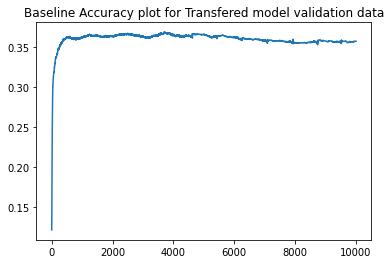

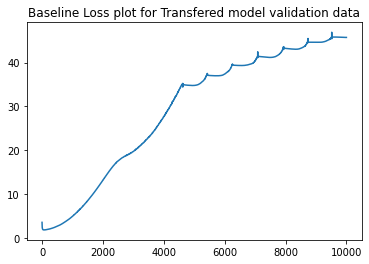

In [ ]:
plt.plot(transfer_model.history.history["val_accuracy"])
plt.title("Baseline Accuracy plot for Transfered model validation data")
plt.show()

plt.plot(transfer_model.history.history["val_loss"])
plt.title("Baseline Loss plot for Transfered model validation data")
plt.show()

In [ ]:
transfered_data = [transfer_model.history.history["val_accuracy"][0]]
normal_data = [model_500_baseline.history.history["val_accuracy"][0]]
for i in range(1, 10001):
    if i % 100 == 0 and i != 0:
        normal_data.append(model_500_baseline.history.history["val_accuracy"][i-1])
        transfered_data.append(transfer_model.history.history["val_accuracy"][i-1])
        

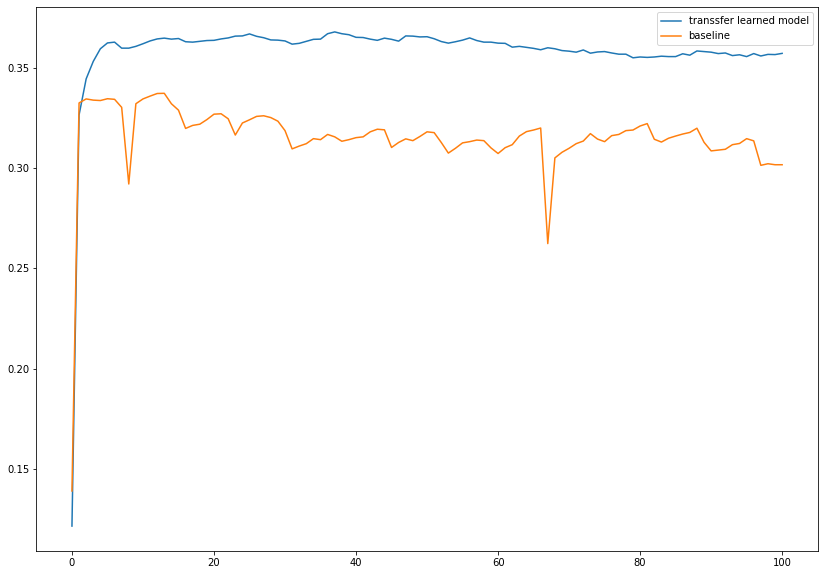

In [ ]:
fig = plt.figure(figsize = (14,10))
plt.plot(transfered_data, label="transsfer learned model")
plt.plot(normal_data, label = "baseline")
plt.legend()

Another way of training is to set weights seperately for each layer as done below

In [ ]:
loaded_3class_model = Model(final_layer_units=3)
loaded_3class_model.compile(metrics = ['accuracy'],
                  loss = 'categorical_crossentropy',
                  optimizer = 'adam')
loaded_3class_model.load_weights("/content/drive/MyDrive/model/weights_question2_3classes.h5")

question3_3rd_final_model = Model()
for i, layer in enumerate(loaded_3class_model.layers[:-1]):
    question3_3rd_final_model.layers[i].set_weights(layer.get_weights())

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    tf.keras.optimizers.Adam()
]
optimizers_and_layers = [(optimizers[0], question3_3rd_final_model.layers[:-1]),  
                         (optimizers[1], question3_3rd_final_model.layers[-1])]
optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

question3_3rd_final_model.compile(metrics = ['accuracy'],
            loss = 'categorical_crossentropy',
            optimizer = optimizer)

question3_3rd_final_model.fit(ds_train_500, validation_data = ds_val, epochs=10)

Epoch 1/10
32/32 [==============================] - 1s 8ms/step - loss: 3.5257 - accuracy: 0.0980 - val_loss: 3.4222 - val_accuracy: 0.0885
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 3.1593 - accuracy: 0.1120 - val_loss: 3.1335 - val_accuracy: 0.0992
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 2.9163 - accuracy: 0.1340 - val_loss: 2.9406 - val_accuracy: 0.1118
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 2.7487 - accuracy: 0.1440 - val_loss: 2.8047 - val_accuracy: 0.1239
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 2.6258 - accuracy: 0.1680 - val_loss: 2.7021 - val_accuracy: 0.1356
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 2.5291 - accuracy: 0.1820 - val_loss: 2.6199 - val_accuracy: 0.1483
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 2.4485 - accuracy: 0.1860 - val_loss: 2.5513 - val_accuracy: 0.1596
Epoch 8/10
32/32 [==

# Part 3

Following methods do the followning task:
- SNR_numpy - gives the SNR values of the example
- get_vectors - converts the time series into absolute valued matrix

In [ ]:
def SNR_numpy(y_truth, y_pred):
    # y_pred = y_pred[:y_truth.shape[0]]
    return 10*np.log10(np.sum(y_truth**2)/np.sum(y_truth - y_pred)**2)

def get_vectors(vec, col = 180):
    vec = librosa.stft(vec, n_fft=1024, hop_length=512)
    abs_vec = np.zeros((col, 513))
    abs_vec[:vec.T.shape[0]] = np.abs(vec.T)
    return abs_vec

Taking all the traiining files in the 'tr' folder and converting into a (1200,180,513) matrix where 180 is the padded length of the example

In [ ]:
train_noisy = []
clean_noise = []
source_noise = []
target_train = []

for idx in range(1200):
    if len(str(idx)) == 1:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/tr/trx000{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/tr/trs000{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/tr/trn000{str(idx)}.wav', sr=None)
    elif len(str(idx)) == 2:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/tr/trx00{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/tr/trs00{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/tr/trn00{str(idx)}.wav', sr=None)
    elif len(str(idx)) == 3:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/tr/trx0{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/tr/trs0{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/tr/trn0{str(idx)}.wav', sr=None)
    else:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/tr/trx{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/tr/trs{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/tr/trn{str(idx)}.wav', sr=None)

    train_noisy.append(get_vectors(noisy))

    clean_noise.append(get_vectors(clean))
    source_noise.append(get_vectors(source))

    target_train.append((get_vectors(clean) > get_vectors(source)).astype('uint8'))

train_noisy = np.stack(train_noisy)
target_train = np.stack(target_train)

Shape of the training set and taregt 

In [ ]:
target_train.shape, train_noisy.shape

((1200, 180, 513), (1200, 180, 513))

Taking all the validation files in the 'v' folder and converting into a (1200,180,513) matrix where 180 is the padded length of the example

In [ ]:
val_noisy = []
clean_noise_val = []
source_noise_val = []
target_val = []

for idx in range(1200):
    if len(str(idx)) == 1:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/v/vx000{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/v/vs000{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/v/vn000{str(idx)}.wav', sr=None)
    elif len(str(idx)) == 2:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/v/vx00{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/v/vs00{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/v/vn00{str(idx)}.wav', sr=None)
    elif len(str(idx)) == 3:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/v/vx0{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/v/vs0{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/v/vn0{str(idx)}.wav', sr=None)
    else:
        noisy, sr_noisy = librosa.load(f'/content/drive/MyDrive/timit/v/vx{str(idx)}.wav', sr=None)
        clean, sr_clean = librosa.load(f'/content/drive/MyDrive/timit/v/vs{str(idx)}.wav', sr=None)
        source, sr_source = librosa.load(f'/content/drive/MyDrive/timit/v/vn{str(idx)}.wav', sr=None)

    val_noisy.append(get_vectors(noisy))
    clean_noise_val.append(get_vectors(clean))
    source_noise_val.append(get_vectors(source))

    target_val.append((get_vectors(clean) > get_vectors(source)).astype('uint8'))

val_noisy = np.stack(val_noisy)
target_val = np.stack(target_val)

Shape of the validation set and the validation target set

In [ ]:
target_val.shape, val_noisy.shape

((1200, 180, 513), (1200, 180, 513))

## Model & Training
Model for the training



In [ ]:
model = tf.keras.Sequential([
                             tf.keras.Input(shape=(None,513)),
                             tf.keras.layers.LSTM(513, return_sequences=True),
                            #  tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(513, return_sequences=True),
                            #  tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(620, activation = 'sigmoid'),
                             tf.keras.layers.Dense(513, activation = 'sigmoid'),
                            #  tf.keras.layers.Lambda(lambda x: tf.where(x > 0.5, 1, 0))
])
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = ['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 513)         2107404   
_________________________________________________________________
dropout (Dropout)            (None, None, 513)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 513)         2107404   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 513)         0         
_________________________________________________________________
dense (Dense)                (None, None, 620)         318680    
_________________________________________________________________
dense_1 (Dense)              (None, None, 513)         318573    
Total params: 4,852,061
Trainable params: 4,852,061
Non-trainable params: 0
______________________________________________

In [ ]:
model.fit(train_noisy, target_train, 
          validation_data = (val_noisy, target_val), 
          batch_size = 10, epochs = 50)

Epoch 1/50
120/120 [==============================] - 17s 101ms/step - loss: 0.4035 - binary_accuracy: 0.7596 - val_loss: 0.3694 - val_binary_accuracy: 0.7768
Epoch 2/50
120/120 [==============================] - 11s 88ms/step - loss: 0.3439 - binary_accuracy: 0.8159 - val_loss: 0.3244 - val_binary_accuracy: 0.8382
Epoch 3/50
120/120 [==============================] - 10s 87ms/step - loss: 0.3058 - binary_accuracy: 0.8493 - val_loss: 0.2785 - val_binary_accuracy: 0.8703
Epoch 4/50
120/120 [==============================] - 10s 88ms/step - loss: 0.2820 - binary_accuracy: 0.8643 - val_loss: 0.2672 - val_binary_accuracy: 0.8742
Epoch 5/50
120/120 [==============================] - 10s 84ms/step - loss: 0.2670 - binary_accuracy: 0.8731 - val_loss: 0.2629 - val_binary_accuracy: 0.8753
Epoch 6/50
120/120 [==============================] - 10s 85ms/step - loss: 0.2556 - binary_accuracy: 0.8803 - val_loss: 0.2434 - val_binary_accuracy: 0.8873
Epoch 7/50
120/120 [==============================]

## SNR values for the validation set

In [ ]:
avg_snr = 0
for idx in range(1200):
    if len(str(idx)) == 1:
        file_signal_name, file_clean_name = f'vx000{str(idx)}', f'vs000{str(idx)}'
    elif len(str(idx)) == 2:
        file_signal_name, file_clean_name = f'vx00{str(idx)}', f'vs00{str(idx)}'
    elif len(str(idx)) == 3:
        file_signal_name, file_clean_name = f'vx0{str(idx)}', f'vs0{str(idx)}'
    else:
        file_signal_name, file_clean_name = f'vx{str(idx)}', f'vs{str(idx)}'

    test1, sr_test = librosa.load('/content/drive/MyDrive/timit/v/'+file_signal_name+'.wav', sr=None)
    test_clean, sr_test_clean = librosa.load('/content/drive/MyDrive/timit/v/'+file_clean_name+'.wav', sr=None)
    vec = librosa.stft(test1, n_fft=1024, hop_length=512)
    vec_clean = librosa.stft(test_clean, n_fft=1024, hop_length=512)

    pred = np.where(model.predict(np.expand_dims(np.abs(vec.T), axis=0))> 0.5, 1, 0)
    a = np.multiply(vec.T, np.squeeze(pred))
    snr = SNR_numpy(librosa.istft(vec_clean, hop_length=512), librosa.istft(a.T, hop_length=512))
    avg_snr+=snr
    print("File name: ", file_signal_name)
    print(snr)
    print()

File name:  vx0000
17.284214703058772

File name:  vx0001
18.093847393891107

File name:  vx0002
17.188543510177205

File name:  vx0003
15.186146896947987

File name:  vx0004
17.288168412091387

File name:  vx0005
20.690036988252807

File name:  vx0006
16.504524606716036

File name:  vx0007
40.34806527766494

File name:  vx0008
17.291011857842907

File name:  vx0009
17.2818364390395

File name:  vx0010
21.0990269814588

File name:  vx0011
21.36775052233589

File name:  vx0012
36.98137091070754

File name:  vx0013
19.434079112922397

File name:  vx0014
18.79999704267177

File name:  vx0015
20.78964304697127

File name:  vx0016
20.07752369113736

File name:  vx0017
50.611241209568306

File name:  vx0018
18.79901838913516

File name:  vx0019
22.164756485868207

File name:  vx0020
20.361131254118522

File name:  vx0021
23.952411705852175

File name:  vx0022
38.492688040788266

File name:  vx0023
21.289800736690488

File name:  vx0024
20.30694107889913

File name:  vx0025
20.75539171350101


In [ ]:
print("Average SNR for all the validation files is : " , avg_snr/1200)

Average SNR for all the validation files is :  24.914544044108297


## Test files
Converting the test files into .wav files fter running the model on them and removing the noice to its best capability.

In [ ]:
def predict_signal(file_path, file_name, model):
    test1, sr_test = librosa.load(file_path, sr=None)
    vec = librosa.stft(test1, n_fft=1024, hop_length=512)
    pred = np.where(model.predict(np.expand_dims(np.abs(vec).T, axis=0))> 0.5, 1, 0)
    a = np.multiply(vec.T, np.squeeze(pred))
    sf.write(f'/content/drive/MyDrive/DLS/testfiles/{file_name}.wav', librosa.istft(a.T, hop_length=512), sr_test)

In [ ]:
import soundfile as sf
for idx in range(400):
    if len(str(idx)) == 1:
        file_path, file_name = f'/content/drive/MyDrive/timit/te/tex000{str(idx)}.wav', f'tex000{str(idx)}'
    elif len(str(idx)) == 2:
        file_path, file_name = f'/content/drive/MyDrive/timit/te/tex00{str(idx)}.wav', f'tex00{str(idx)}'
    else:
        file_path, file_name = f'/content/drive/MyDrive/timit/te/tex0{str(idx)}.wav', f'tex0{str(idx)}'
    predict_signal(file_path, file_name, model)